In [25]:
import re  # Procesamiento de Texto
import pandas as pd  
from time import time  # Medir tiempo de ejecucion
import multiprocessing
import logging  # Sacar logs del modelo

import numpy as np
import matplotlib.pyplot as plt
 
import seaborn as sns

from collections import defaultdict  
from sklearn.model_selection import train_test_split

import spacy  # Procesamiento NLP

In [26]:
# DATA DIR 
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/simpson_dataset.csv'
# cargamos datos 
df = pd.read_csv(url)
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [27]:
df = df.dropna().reset_index(drop=True) # eliminamos nulos 

# Filtrando Homero 

df['is_homer'] = [
    1 if "homer" in x.lower() else 0 for x
    in df.raw_character_text
]

In [28]:
df.is_homer.value_counts() / len(df) 

0    0.78451
1    0.21549
Name: is_homer, dtype: float64

<AxesSubplot:>

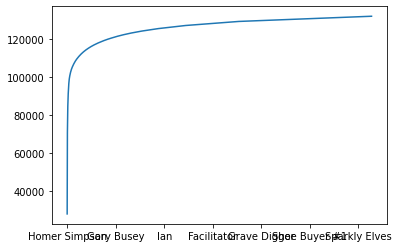

In [29]:
# Vemos el plot cumulativo donde tenemos los personas menos relevantes
df.raw_character_text.value_counts().cumsum().plot()

In [30]:
cumsum_participation = df.raw_character_text.value_counts().cumsum()
mask = cumsum_participation <= 110_000
rel_characters = cumsum_participation[mask].index
# Filter for the relevant characters
df = df[df.raw_character_text.isin(rel_characters)]

In [31]:
df.is_homer.value_counts() / len(df) 

0    0.744104
1    0.255896
Name: is_homer, dtype: float64

In [32]:
len(df)

109982

# Reducimos tamaño del DF para evitar problemas de memoria

In [33]:
# reducimos a la 50% de los not homer
# Esto también nos ayudará a balancear el modelo

sample_size = int(
     len(
         df.query(
            "is_homer == 0"
        )
    ) * 0.5
)
to_model_df = df.query(
    "is_homer == 1"
).append(
    df.query(
        "is_homer == 0"
).sample(sample_size)
).reset_index(drop=True)

/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_3213/3182038189.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  to_model_df = df.query(


In [34]:
to_model_df.is_homer.value_counts() / len(to_model_df) 

0    0.592488
1    0.407512
Name: is_homer, dtype: float64

In [35]:
len(to_model_df)

69063

In [36]:
to_model_sample_size = 20_000  # pueden incluso disminuir este valor
to_model_df = to_model_df.sample(to_model_sample_size)

In [37]:
to_model_df.is_homer.value_counts() / len(to_model_df) 

0    0.58965
1    0.41035
Name: is_homer, dtype: float64

In [38]:
nlp = spacy.load(
  'en_core_web_sm',  # Capaz sea necesario descargar modelo de Spacy English.
  disable=['ner', 'parser']  # desactivamos modelos por facilidad de procesamiento
  ) 

def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  txt = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec usa el contexto para entender la reperesentacion de la palabra
  # Si la oracion es corta, no va a aprender mucho
  return ' '.join(txt)
# Reemplazamos todo lo que no sea alphanum por espacio
brief_cleaning = (
  re.sub(r"[^A-Za-z0-9']+", 
  ' ', 
  str(row)).lower().strip() for row in to_model_df['spoken_words']  # por cada fila en df.
  )

In [39]:
# Usamos el método Pipe de Spacy para procesar con mayor velocidad
t = time() # Calculamos tiempo

txt = [
    cleaning(doc) for doc in nlp.pipe(
        brief_cleaning, # función que def antes
        batch_size=5000, 
        n_process=-1 # usamos todos los cores
    )
]
# medimos tiempo de ejecución 
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

In [17]:
to_model_df['clean_txt'] = txt
to_model_df = to_model_df[to_model_df.clean_txt.notnull()]

In [18]:
len(to_model_df)

12982

In [19]:
Y = to_model_df.is_homer.values
X = to_model_df.clean_txt

# Set entrenamiento y prueba con Keras
df_train, df_test, Ytrain, Ytest = train_test_split(
    X, Y, test_size=0.30, stratify=Y
)

A modelar se ha dicho!